In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import warnings
import sqlite3
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import folium
from folium.plugins import HeatMapWithTime, TimestampedGeoJson
import plotly.express as px
import re
import neattext.functions as nfx
from textblob import TextBlob


In [9]:
os.chdir('/Users/mafer/Documents/Tec/ArteLitica/Herramientas-computacionales-el-arte-de-la-anal-tica/Reto')

In [10]:
os.getcwd()

'/Users/mafer/Documents/Tec/ArteLitica/Herramientas-computacionales-el-arte-de-la-anal-tica/Reto'

### Mafer

Realizar un análisis del comportamiento y posición geográfica de los datos agrupados por día utilizando la ubicación, latitud y longitud como apoyo.

In [16]:
tweets = pd.read_csv('covid19_tweets 2.csv')
cities = pd.read_csv('worldcities.csv')

In [17]:
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [18]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [ ]:
tweets["lat"] = np.NaN
tweets["lng"] = np.NaN
tweets["location"] = tweets["user_location"]
user_location = tweets['location'].fillna(value='').str.split(',')
avg_countries_loc = pd.read_csv('https://gist.githubusercontent.com/tadast/8827699/raw/3cd639fa34eec5067080a61c69e3ae25e3076abb/countries_codes_and_coordinates.csv')


# Make a list of all countries in Avg Location Dataset
codes = avg_countries_loc['Alpha-2 code'].str.replace('"','').str.strip().to_list()
codes = avg_countries_loc['Alpha-2 code'].str.replace('"','').str.strip().to_list() + ['XW','SX', 'CW','XK']
code_lat = avg_countries_loc['Latitude (average)'].str.replace('"','').to_list() + ['31.953112', '18.0255', '12.2004', '42.609778']
code_lng = avg_countries_loc['Longitude (average)'].str.replace('"','').to_list() + ['35.301170', '-63.0450', '-69.0200', '20.918062']
lat = cities['lat'].fillna(value = '').values.tolist()
lng = cities['lng'].fillna(value = '').values.tolist()

lat = cities['lat'].fillna(value = '').values.tolist()
lng = cities['lng'].fillna(value = '').values.tolist()


# Getting all alpha 3 codes into  a list
world_city_iso3 = []
for c in cities['iso3'].str.lower().str.strip().values.tolist():
    if c not in world_city_iso3:
        world_city_iso3.append(c)
        
# Getting all alpha 2 codes into  a list    
world_city_iso2 = []
for c in cities['iso2'].str.lower().str.strip().values.tolist():
    if c not in world_city_iso2:
        world_city_iso2.append(c)
        
# Getting all countries into  a list        
world_city_country = []
for c in cities['country'].str.lower().str.strip().values.tolist():
    if c not in world_city_country:
        world_city_country.append(c)

# Getting all amdin names into  a list
world_states = []
for c in cities['admin_name'].str.lower().str.strip().tolist():
    world_states.append(c)


# Getting all cities into  a list
world_city = cities['city'].fillna(value = '').str.lower().str.strip().values.tolist()


for each_loc in range(len(user_location)):
    ind = each_loc
    order = [False,False,False,False,False]
    each_loc = user_location[each_loc]
    for each in each_loc:
        each = each.lower().strip()
        if each in world_city:
            order[0] = world_city.index(each)
        if each in world_states:
            order[1] = world_states.index(each)
        if each in world_city_country:
            order[2] = world_city_country.index(each)
        if each in world_city_iso2:
            order[3] = world_city_iso2.index(each)
        if each in world_city_iso3:
            order[4] = world_city_iso3.index(each)

    if order[0]:
        tweets['lat'][ind] = lat[order[0]]
        tweets['lng'][ind] = lng[order[0]]
        continue
    if order[1]:
        tweets['lat'][ind] = lat[order[1]]
        tweets['lng'][ind] = lng[order[1]]
        continue
    if order[2]:
        try:
            tweets['lat'][ind] = code_lat[codes.index(world_city_iso2[order[2]].upper())]
            tweets['lng'][ind] = code_lng[codes.index(world_city_iso2[order[2]].upper())]
        except:
            pass
        continue
    if order[3]:
        tweets['lat'][ind] = code_lat[codes.index(world_city_iso2[order[3]].upper())]
        tweets['lng'][ind] = code_lng[codes.index(world_city_iso2[order[3]].upper())]
        continue
    if order[4]:
        tweets['lat'][ind] = code_lat[codes.index(world_city_iso2[order[4]].upper())]
        tweets['lng'][ind] = code_lng[codes.index(world_city_iso2[order[4]].upper())]
        continue
        
    
    
    # Null values of location in tweets
all_tweets = len(tweets)
bad_tweets_without_location = tweets['user_location'].isnull().sum()
tweets_unrecovered_location = tweets['lat'].isnull().sum()

print(all_tweets, bad_tweets_without_location, tweets_unrecovered_location)
print('\nPercentage of recovering Tweet Locations using extrenal datasets...')
print((all_tweets-(tweets_unrecovered_location))/(all_tweets-bad_tweets_without_location))

In [ ]:
map_df = tweets[['lat','lng','user_location','date']].dropna()
dates = map_df['date'].str.split(' ').str.get(0).unique().tolist()
print('Number of Days in dataset:', len(dates))

daily_tweets = folium.Map(tiles='cartodbpositron', min_zoom=2) 

# Ensure you're handing it floats
map_df['lat'] = map_df['lat'].astype(float)
map_df['lng'] = map_df['lng'].astype(float)
map_df['date'] = map_df['date'].str.split(' ').str.get(0)


# List comprehension to make out list of lists
heat_data = [[[row['lat'],row['lng']] for index, row in map_df[map_df['date'] == i].iterrows()] for i in dates]

# Plot it on the map
hm = HeatMapWithTime(data=heat_data, name=None, radius=7, min_opacity=0, max_opacity=0.8, 
                     scale_radius=False, gradient=None, use_local_extrema=False, auto_play=False, 
                     display_index=True, index_steps=1, min_speed=0.1, max_speed=10, speed_step=0.1, 
                     position='bottomleft', overlay=True, control=True, show=True)
hm.add_to(daily_tweets)
# Display the map
daily_tweets.save('daily_tweets.html')
daily_tweets

### Kari

S 
Análisis de los tweets para obtener la información sobre las cuentas con publicaciones referentes al COVID-19.
M 
La cantidad tweets desde el tiempo inicial hasta el tiempo final
A 
Con ayuda de los códigos creados por otras personas en kaggle
R 
Para poder obtener una idea sobre el movimiento de información conforme al país
T 
En un plazo de 2006 (inicio de los tweets) a 2020 (fecha de los últimos datos)


Meta SMART: Realizar un análisis de los tweets para obtener la información sobre las cuentas con publicaciones referentes al COVID-19, se medirá la cantidad de tweets publicados desde el año 2006 (año en el que se creó la cuenta más vieja en publicar referente al tema), hasta el 2020 (último año del que se tiene información en la base de datos). Esto se logrará con la ayuda de los códigos creados por usuarios varios de kaggle. Esta información es relevante porque nos ayuda a tener una idea sobre el movimiento de la información conforme al país o conforme a la cuenta que lo publique.

In [ ]:
import plotly.express as px

fig = px.bar(x=tweets.user_location.value_counts().index[:10],
            y=tweets.user_location.value_counts().values[:10],
            title="<b>Cantidad de tweets por país<b>")
fig.update_layout(xaxis_title="País", yaxis_title="Cantidad de tweets",title_x=0.5)

fig.show()

Source top users

In [18]:
df_username_count = tweets['user_name'].value_counts().reset_index().rename(columns={
    'user_name':'tweet_count','index':'user_name'})
fig =  px.treemap(df_username_count.head(30), path=['user_name'], values='tweet_count',
                title="<b>Top 30 usuarios (Por número de tweets)</b>", color='tweet_count') 

fig.show()

Frecuencia en la que se tuiteó

In [11]:
import plotly.graph_objs as go


tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['year_created'] = tweets['user_created'].dt.year

data2 = tweets['year_created'].value_counts().reset_index().rename(columns = {
    'year_created' : 'count', 'index' : 'year_added'}).sort_values('year_added')[1:] # Since twitter was started from 2006
data2['percent'] = data2['count'].apply(lambda x : 100*x/sum(data2['count']))

t1 = go.Scatter(x=data2['year_added'], y=data2["count"], marker=dict(color="#a678de"))

layout = go.Layout(title="<b>Cantidad de cuentas creadas por año</b>", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(t1, layout=layout)
fig.update_layout(xaxis_title="Año", yaxis_title="Cantidad de usuarios",title_x=0.5)
fig.show()

### Sebas

S Determinar los patrones de las fuentes y sentimientos expresados dentro de los tweets. Así como de la comparación de followers con respecto a la cantidad de favourites y friends.
M El objetivo abarca hasta el resultado de las graficas, wordclouds y valores centrales
A Con las habilidades aprendidas esta semana Tec con el uso de Python y pandas y sus diversas librerías. Se tomó como inspiración los notebooks de kaggle, para la falicitación del código
R Es importante conocer los patrones para identificar la verosimilidad de los tweets (fuetes) así como identificar de que forma se expresan los usuarios.
T El tiempo contenido en la base de datos

In [20]:
tweets.describe()

,user_followers,user_friends,user_favourites,year_created
count,1.791080e+05,179108.000000,1.791080e+05,179108.000000
mean,1.090555e+05,2121.701566,1.444411e+04,2013.650111
std,8.414670e+05,9162.553072,4.452270e+04,4.032554
min,0.000000e+00,0.000000,0.000000e+00,1970.000000
25%,1.720000e+02,148.000000,2.060000e+02,2010.000000
50%,9.920000e+02,542.000000,1.791000e+03,2013.000000
75%,5.284000e+03,1725.250000,9.388000e+03,2017.000000
max,4.944256e+07,497363.000000,2.047197e+06,2020.000000


In [21]:
tweets.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'lat', 'lng',
       'location', 'year_created'],
      dtype='object')

In [22]:
tweets.dtypes

user_name                   object
user_location               object
user_description            object
user_created        datetime64[ns]
user_followers               int64
user_friends                 int64
user_favourites              int64
user_verified                 bool
date                        object
text                        object
hashtags                    object
source                      object
is_retweet                    bool
lat                         object
lng                         object
location                    object
year_created                 int64
dtype: object

In [23]:
tweets['source'].value_counts().nlargest(5)

Twitter Web App        56891
Twitter for Android    40179
Twitter for iPhone     35472
TweetDeck               8543
Hootsuite Inc.          7321
Name: source, dtype: int64

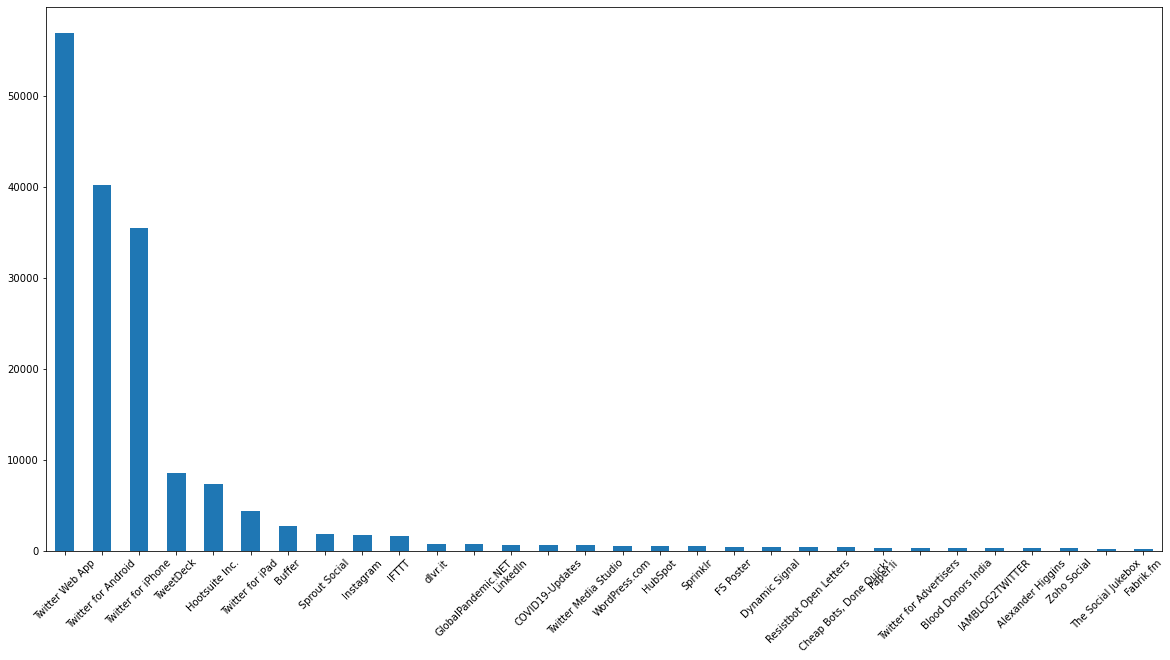

In [25]:
plt.figure(figsize=(20,10))
tweets['source'].value_counts().nlargest(30).plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Create a function to clean tweets
def clean_tweets(text):
    # Remove mentions/handles
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # Remove hashtags
    text = re.sub(r'#', '', text)
    # Remove retweeets(RT)
    text = re.sub(r'RT[\s]+', '', text)
    # Remove urls
    text = re.sub(r'https?:/\/\S+', '', text)
    # Remove punctuations
    text = nfx.remove_puncts(text)
    # Remove multiple spaces
    text = nfx.remove_multiple_spaces(text)
    # Remove emojis
    text = nfx.remove_emojis(text)
    # Remove special characters
    text = nfx.remove_special_characters(text)
    # Convert all text to lowercase
    text = text.lower()
    return text

tweets['clean_tweet'] = tweets['text'].apply(clean_tweets)
tweets['clean_tweet'].iloc[0]
tweets.iloc[0]

user_name                                                      ᏉᎥ☻լꂅϮ
user_location                                              astroworld
user_description    wednesday addams as a disney princess keepin i...
user_created                                      2017-05-26 05:46:42
user_followers                                                    624
user_friends                                                      950
user_favourites                                                 18775
user_verified                                                   False
date                                              2020-07-25 12:27:21
text                If I smelled the scent of hand sanitizers toda...
hashtags                                                          NaN
source                                             Twitter for iPhone
is_retweet                                                      False
lat                                                               NaN
lng                 

In [27]:
# Create a function to get to get the subjectivity and Polarity
def getSentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    result = {'polarity' : sentiment_polarity,
              'subjectivity' : sentiment_subjectivity,
              'sentiment': sentiment_label}
    return result
tweets['sentiment_results'] = tweets['clean_tweet'].apply(getSentiment)
tweets['sentiment_results'].head()

0    {'polarity': -0.25, 'subjectivity': 0.25, 'sen...
1    {'polarity': 0.5, 'subjectivity': 0.5, 'sentim...
2    {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
3    {'polarity': 0.0, 'subjectivity': 0.3571428571...
4    {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
Name: sentiment_results, dtype: object

In [28]:
tweets = tweets.join(pd.json_normalize(tweets['sentiment_results']))

In [29]:
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,is_retweet,lat,lng,location,year_created,clean_tweet,sentiment_results,polarity,subjectivity,sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,...,False,NaN,NaN,astroworld,2017,if i smelled the scent of hand sanitizers toda...,"{'polarity': -0.25, 'subjectivity': 0.25, 'sen...",-0.25,0.250000,Negative
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,...,False,40.6943,-73.9249,"New York, NY",2009,hey and wouldnt it have made more sense to hav...,"{'polarity': 0.5, 'subjectivity': 0.5, 'sentim...",0.50,0.500000,Positive
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,...,False,19.5,-80.5,"Pewee Valley, KY",2009,trump never once claimed covid19 was a hoax w...,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,...,False,NaN,NaN,Stuck in the Middle,2019,the one gift covid19 has give me is an apprec...,"{'polarity': 0.0, 'subjectivity': 0.3571428571...",0.00,0.357143,Neutral
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,...,False,NaN,NaN,Jammu and Kashmir,2017,25 july media bulletin on novel coronavirusup...,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral


In [30]:
tweets['sentiment'].value_counts()

Positive    74830
Neutral     74110
Negative    30168
Name: sentiment, dtype: int64

C:\Users\oso_p\anaconda3\envs\herramientas\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='sentiment', ylabel='count'>

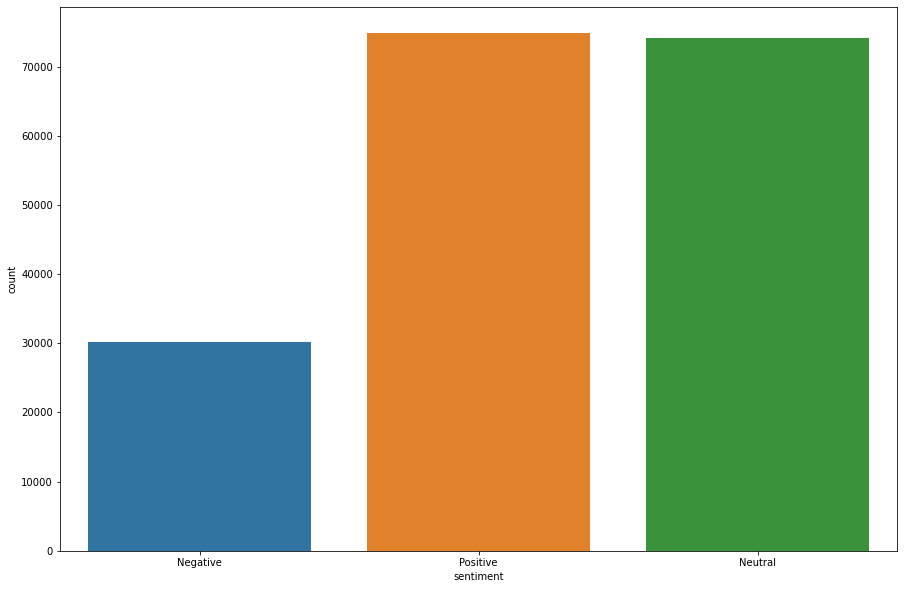

In [31]:
sns.countplot(tweets['sentiment'])

In [32]:
positive_tweets = tweets.query('sentiment == "Positive"')['clean_tweet']

negative_tweets = tweets.query('sentiment == "Negative"')['clean_tweet']

neutral_tweets = tweets.query('sentiment == "Neutral"')['clean_tweet']

# Create a function to remove stopwords and convert to tokens
def stop_token(df):
    df_list = df.apply(nfx.remove_stopwords).tolist()
    # Tokenization
    token = [token for line in df_list for token in line.split()]
    return token
positive_tokens = stop_token(positive_tweets)
negative_tokens = stop_token(negative_tweets)
neutral_tokens = stop_token(neutral_tweets)

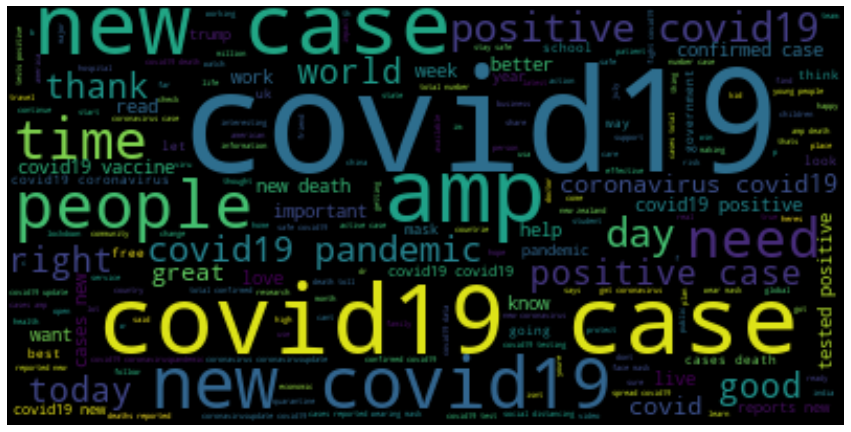

In [33]:
def plotWordCloud(tokens):
    sentiment_dox = ' '.join(tokens)
    word_cloud = WordCloud().generate(sentiment_dox)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plotWordCloud(positive_tokens)

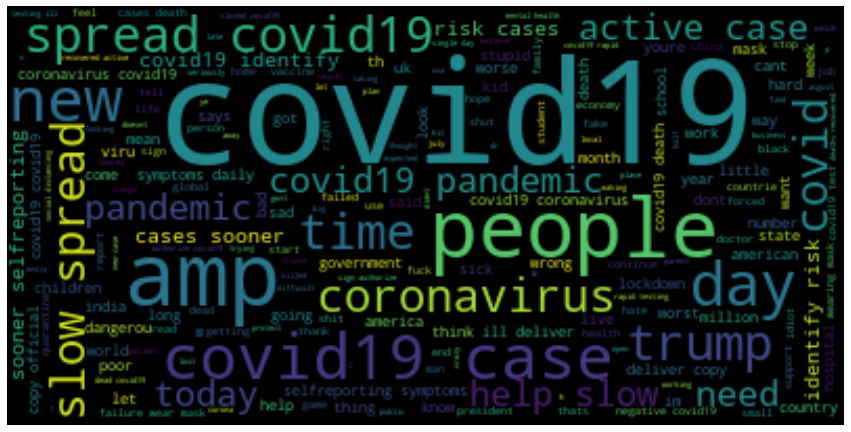

In [34]:
plotWordCloud(negative_tokens)

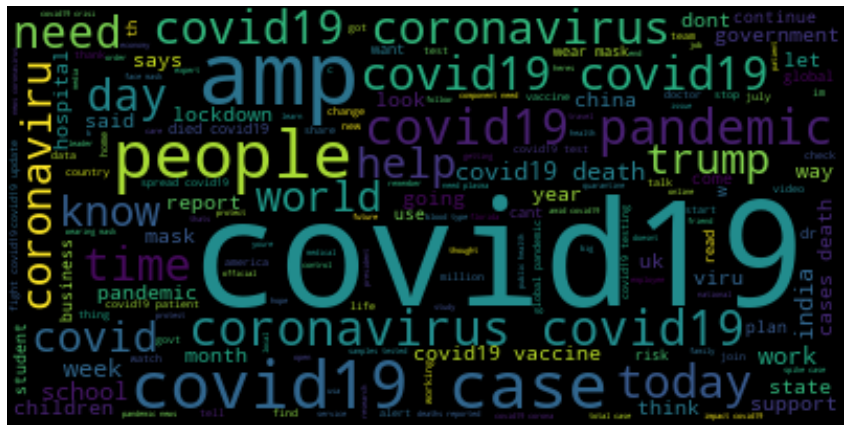

In [35]:
plotWordCloud(neutral_tokens)

In [37]:
print(tweets.groupby('source').size())

source
 Xinhua Sports                   1
 autopo.st - @Radio_Lichfield    1
15 Minute Fun                    1
24liveblog                       7
4strat-foresight                 1
                                ..
whatSaoCarlos                    1
www.diolch.wales                 1
xh_scitech                       4
yorkshire-times                  7
Оwly                             8
Length: 610, dtype: int64


In [38]:
X = np.array(tweets[["user_followers","user_friends","user_favourites"]])
y = np.array(tweets['source'])
X.shape

(179108, 3)

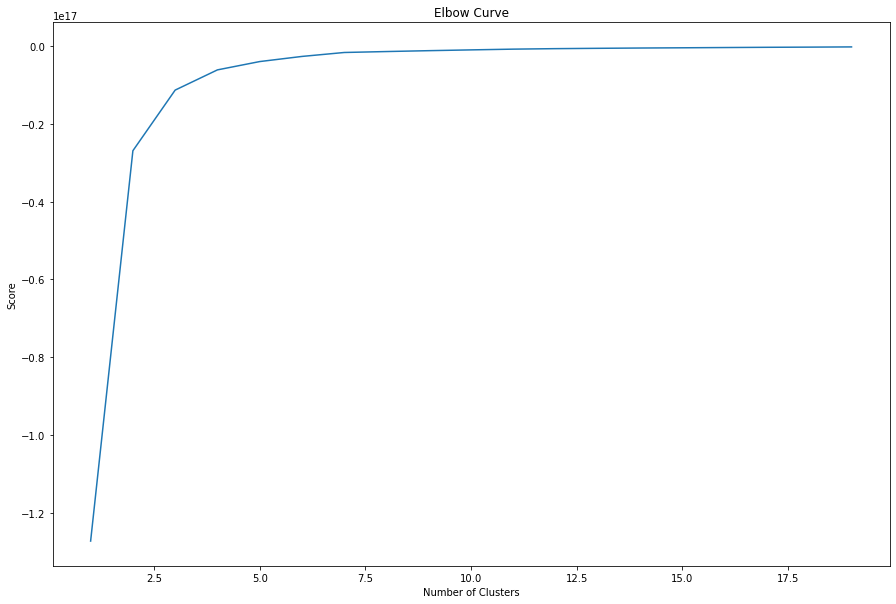

In [39]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [40]:
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[1.62003933e+04 2.14265042e+03 1.46772763e+04]
 [7.27899650e+06 8.13908451e+02 2.65481127e+03]
 [1.31771242e+07 2.41483376e+02 1.23327366e+02]
 [4.56714782e+06 5.80019802e+02 2.81927723e+03]
 [1.58349069e+06 1.65873854e+03 5.02862217e+03]]


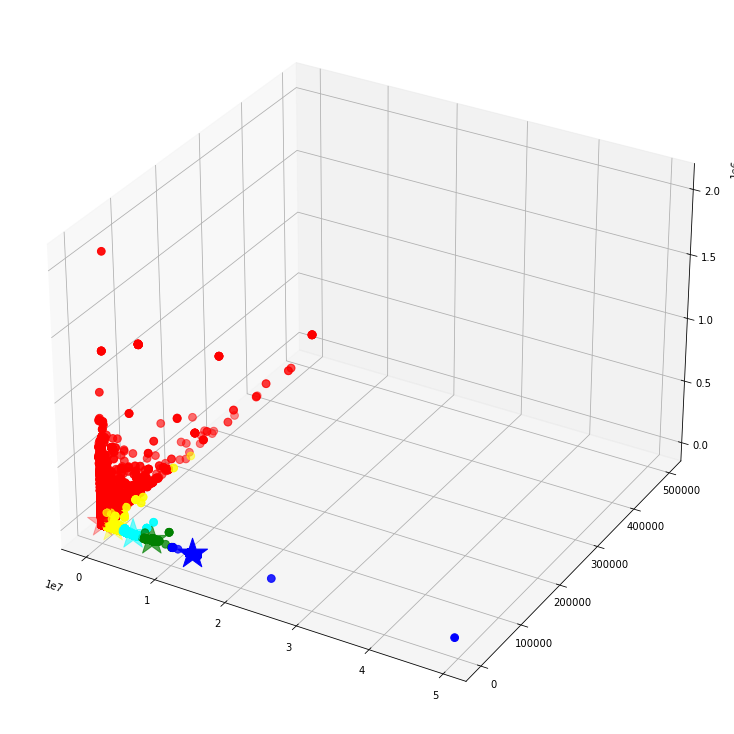

In [41]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

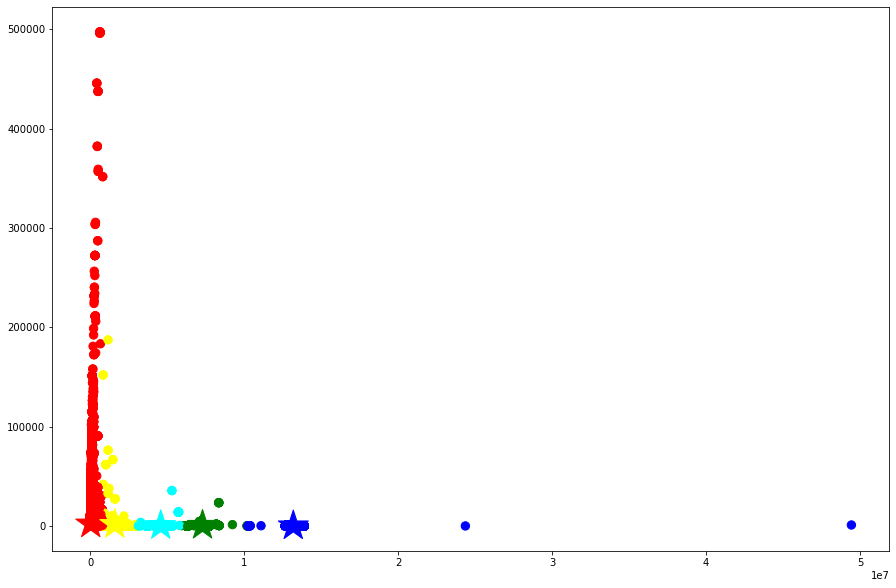

In [42]:
# Getting the values and plotting it
f1 = tweets['user_followers'].values
f2 = tweets['user_friends'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

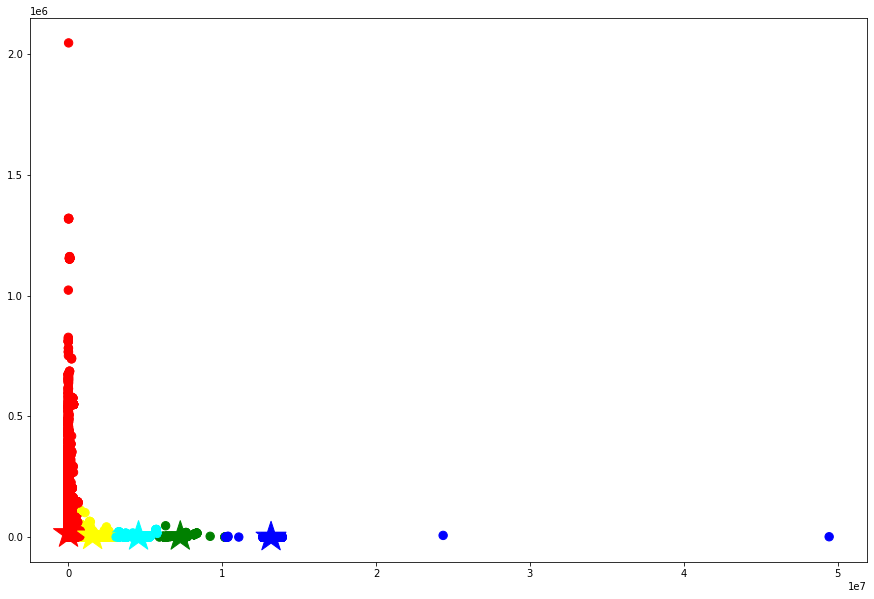

In [43]:
# Getting the values and plotting it
f1 = tweets['user_followers'].values
f2 = tweets['user_favourites'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

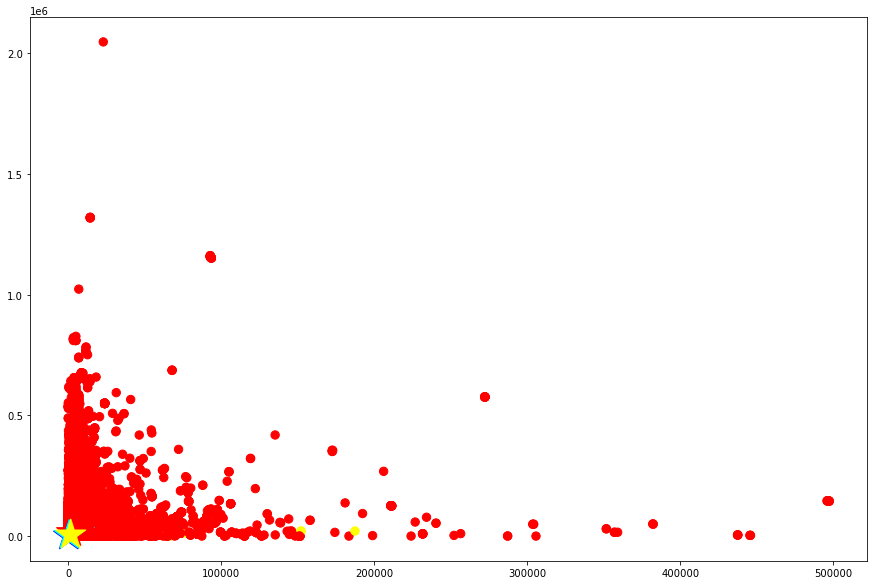

In [44]:
f1 = tweets['user_friends'].values
f2 = tweets['user_favourites'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

In [45]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([ 21742,   7148, 171381,  65352, 154234], dtype=int64)

In [46]:
users=tweets['user_name'].values
for row in closest:
    print(users[row])

Soutik Biswas
Anonymous
The Times Of India
ANI
ONE


### Aram

Objetivo SMART Reto
S - Determinar que país dirige la narrativa del Covid-19 en la red social Twitter 
M - Analizar las locaciones de los tweets y obtener el país con mayor número de tweets
A -Es razonable para nuestras habilidades con analítica de datos
R -Relevante por qué podemos encontrar correlaciones entre que dicen los tweets con intereses geopolíticos y como se usa las redes sociales para promoverlos.
T -Mañana antes de las 12:00

In [47]:
tweet_per_country = tweets['user_location'].str.lower().dropna()
tw = tweet_per_country.value_counts().rename_axis('Country').reset_index(name='Tweet Count')
print(tw)

                          Country  Tweet Count
0                           india         3842
1                   united states         2457
2                       worldwide         1738
3                new delhi, india         1731
4                   mumbai, india         1406
...                           ...          ...
26031      http://amzn.to/291kmbt            1
26032               wilmington nc            1
26033        brasil / canada / us            1
26034           wrexham, wales uk            1
26035  aliwal north, south africa            1

[26036 rows x 2 columns]


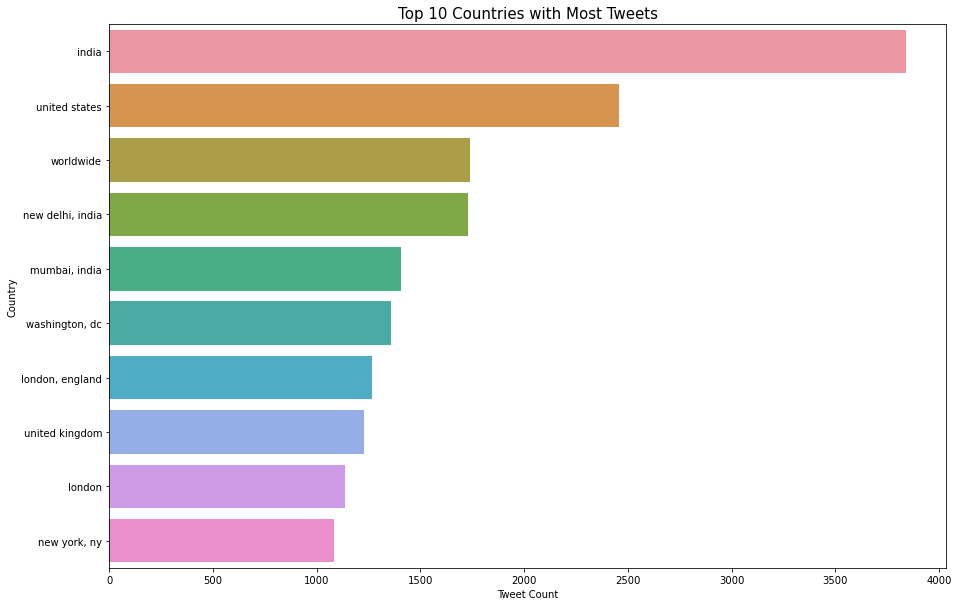

In [48]:
plt.rcParams['figure.figsize'] = (15,10)
plt.title('Top 10 Countries with Most Tweets',fontsize=15)
sns.set_palette("husl")
ax = sns.barplot(y=tw['Country'].head(10),x=tw['Tweet Count'].head(10))

**Andrés Rodríguez**

In [49]:
twepuser = tweets['hashtags'].str.lower().dropna()
tw = twepuser.value_counts().rename_axis('hashtags').reset_index(name='Added to fav')
print(tw)

                                                hashtags  Added to fav
0                                            ['covid19']         45813
1                             ['coronavirus', 'covid19']          1368
2                             ['covid19', 'coronavirus']           919
3                                        ['coronavirus']           880
4      ['coronavirus', 'coronavirusupdate', 'covid19'...           624
...                                                  ...           ...
49372                                  ['trumpisamoron']             1
49373                                        ['elderly']             1
49374                    ['covid19', 'odisha', 'odisha']             1
49375                                           ['tils']             1
49376  ['government', 'beirut', 'unemploymentbenefits...             1

[49377 rows x 2 columns]


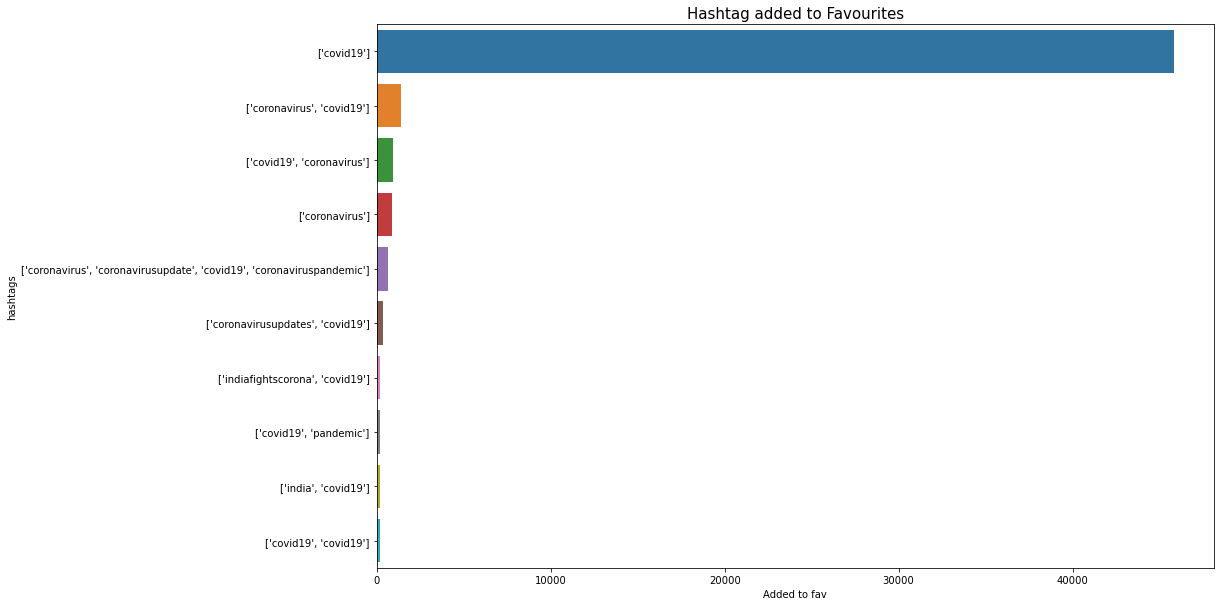

In [50]:
plt.rcParams['figure.figsize'] = (15,10)
plt.title('Hashtag added to Favourites',fontsize=15)
sns.set_palette("tab10")
ax = sns.barplot(y=tw['hashtags'].head(10),x=tw['Added to fav'].head(10))